In [1]:
# Add submodule paths
import sys
sys.path += ['./normalizing_flows', './baselines', './climdex']

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import utils.data as data_util
import utils.nn_util as nn
import xarray as xr
import gcsfs
import climdex.temperature as tdex
import climdex.precipitation as pdex
import logging
import tensorflow_probability as tfp
import utils.metrics as metrics
from baselines.dscnn import create_bmd_cnn10
from tensorflow.keras.models import load_model
from normalizing_flows.models import VariationalModel
from regions import southeast_us, pacific_nw
from datasource import EraiRasDataLoader
from utils.plot import image_map_factory, prcp_cmap
from utils.preprocessing import remove_monthly_means
from utils.distributions import normal
from tqdm import tqdm

correlation = metrics.correlation_metric()

gcs = gcsfs.GCSFileSystem(project='thesis-research-255223', token='gcs.secret.json')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
#tf.autograph.set_verbosity(1)
#tf.config.experimental_run_functions_eagerly(True)
#tf.debugging.set_log_device_placement(True)

In [3]:
data = EraiRasDataLoader(gcs_bucket='erai-rasmussen', gcs_project='thesis-research-255223', auth='gcs.secret.json')
# era-interim
erai_deg1 = xr.open_zarr(data.erai('daily-1deg'), consolidated=True).clip(min=0.0, max=np.inf)
# 1-degree regridded rasmussen
ras_deg1 = xr.open_zarr(data.rasmussen('daily-1deg'), consolidated=True).clip(min=0.0, max=np.inf)
# 1/2-degree regridded rasmussen
ras_deg12 = xr.open_zarr(data.rasmussen('daily-1-2deg'), consolidated=True).clip(min=0.0, max=np.inf)
ras_deg14 = xr.open_zarr(data.rasmussen('daily-1-4deg'), consolidated=True).clip(min=0.0, max=np.inf)
ras_deg18 = xr.open_zarr(data.rasmussen('daily-1-8deg'), consolidated=True).clip(min=0.0, max=np.inf)
ras_deg116 = xr.open_zarr(data.rasmussen('daily-1-16deg'), consolidated=True)
def get_train_test_splits(data_lo, data_hi, region_fn, scale):
    data_lo = region_fn(data_lo)
    data_hi = region_fn(data_hi, scale_factor=scale)
    lr_train = data_lo.isel(Time=slice(0,data_lo.Time.size-2*365))
    lr_test = data_lo.isel(Time=slice(data_lo.Time.size-2*365, data_lo.Time.size+1))
    hr_train = data_hi.isel(Time=slice(0,data_lo.Time.size-2*365))
    hr_test = data_hi.isel(Time=slice(data_lo.Time.size-2*365, data_lo.Time.size+1))
    return lr_train, lr_test, hr_train, hr_test

In [9]:
def plot_random_lr_hr_pairs(data_lr, data_hr, epsilon_prcp=1.0, i=None):
    if i is None:
        i = np.random.randint(0, data_lr.Time.size)
    maxt_lr = data_lr['MAXT'][i]
    maxt_hr = data_hr['MAXT'][i]
    prcp_lr = data_lr['PRCP'][i]
    prcp_hr = data_hr['PRCP'][i]
    fig, axs, plot_fn = image_map_factory(2, 2, figsize=(6,4))
    pmap = prcp_cmap()
    plot_fn(axs[0,0], maxt_lr, maxt_lr.lat, maxt_lr.lon, title='ERA-I, max temperature', cmap='viridis')
    cs = plot_fn(axs[0,1], maxt_hr, maxt_hr.lat, maxt_hr.lon, title='WRF-8, max temperature', cmap='viridis')
    fig.colorbar(cs, ax=axs[0].ravel().tolist(), orientation='vertical', shrink=0.6, pad=0.01).set_label('max temperature (K)')
    plot_fn(axs[1,0], prcp_lr, prcp_lr.lat, prcp_lr.lon, title='ERA-I, precipitation', cmap=pmap)
    cs = plot_fn(axs[1,1], prcp_hr, prcp_hr.lat, prcp_hr.lon, title='WRF-8, precipitation', cmap=pmap)
    fig.colorbar(cs, ax=axs[1].ravel().tolist(), orientation='vertical', shrink=0.6, pad=0.01).set_label('precipitation (mm)')
    return fig, i

<xarray.DataArray 'Time' ()>
array('2012-08-19T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    Time     datetime64[ns] 2012-08-19


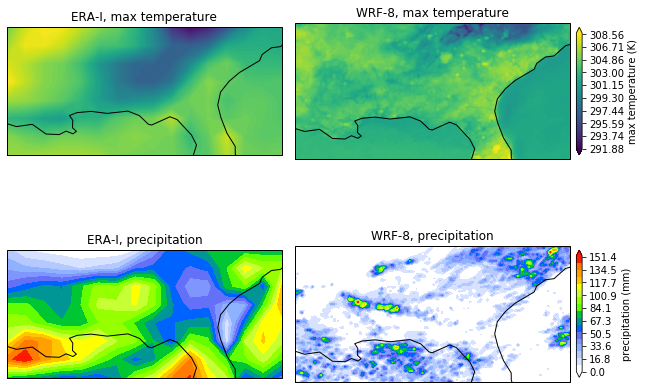

In [5]:
lr_train, lr_test, hr_train, hr_test = get_train_test_splits(erai_deg1, ras_deg18, southeast_us, scale=8)
fig, i = plot_random_lr_hr_pairs(lr_test, hr_test, i=322)
print(hr_test.Time[i])
plt.show()

In [19]:
def metrics_file_uri(experiment_name, run_id, filename='metrics.npz'):
    return f'generative-downscaling-artifact-store/{experiment_name}/{run_id}/artifacts/data/{filename}'

def compute_metrics_maxt(hr_test, metrics):
    indices = tdex.indices('Time', convert_units_fn=lambda x: x+273.15)
    txx_pred = np.array(metrics['txx'])
    txn_pred = np.array(metrics['txn'])
    txid_pred = np.array(metrics['txid'])
    txsd_pred = np.array(metrics['txsd'])
    maxt_hr_test = hr_test['MAXT'].expand_dims({'chan': 1}, axis=-1)
    txx_true = indices.monthly_txx(maxt_hr_test)
    txn_true = indices.monthly_txn(maxt_hr_test)
    txid_true = indices.annual_icing_days(maxt_hr_test)
    txsd_true = indices.annual_summer_days(maxt_hr_test)
    txx_corr = correlation(txx_true.values, txx_pred).numpy()
    txn_corr = correlation(txn_true.values, txn_pred).numpy()
    txsd_corr = correlation(txsd_true.values, txsd_pred).numpy()
    txid_corr = correlation(txid_true.values, txid_pred).numpy()
    return txx_corr, txn_corr, txsd_corr, txid_corr

def compute_metrics_prcp(hr_test, metrics):
    indices = pdex.indices('Time')
    ar20_pred = metrics['ar20'].astype(np.float64)
    prcptot_pred = metrics['atot'].astype(np.float64)
    cdd_pred = metrics['cdd'].astype(np.float64)
    cwd_pred = metrics['cwd'].astype(np.float64)
    rx1_pred = metrics['mrx1'].astype(np.float64)
    rx5_pred = metrics['mrx5'].astype(np.float64)
    prcp_hr_test = hr_test['PRCP'].expand_dims({'chan': 1}, axis=-1)
    ar20_true = indices.annual_r20mm(prcp_hr_test).astype(np.float64)
    prcptot_true = indices.prcptot(prcp_hr_test).astype(np.float64)
    cdd_true = indices.cdd(prcp_hr_test).astype(np.float64)
    cwd_true = indices.cwd(prcp_hr_test).astype(np.float64)
    rx1_true = indices.monthly_rx1day(prcp_hr_test).astype(np.float64)
    rx5_true = indices.monthly_rx5day(prcp_hr_test).astype(np.float64)
    ar20_corr = correlation(ar20_true.values, ar20_pred).numpy()
    prcptot_corr = correlation(prcptot_true.values, prcptot_pred).numpy()
    cdd_corr = correlation(cdd_true.values, cdd_pred).numpy()
    cwd_corr = correlation(cwd_true.values, cwd_pred).numpy()
    rx1_corr = correlation(rx1_true.values, rx1_pred).numpy()
    rx5_corr = correlation(rx5_true.values, rx5_pred).numpy()
    return ar20_corr, prcptot_corr, cdd_corr, cwd_corr, rx1_corr, rx5_corr

### BCSD

In [7]:
# Southeast-US MAXT
lr_train, lr_test, hr_train, hr_test = get_train_test_splits(erai_deg1, ras_deg14, southeast_us, scale=4)
uri = metrics_file_uri('bcsd-final', '558b55bddd6c44cfad5b8b979072e99f')
with gcs.open(uri) as f:
    metrics = np.load(f)
    txx_corr, txn_corr, txsd_corr, txid_corr = compute_metrics_maxt(hr_test, metrics)

correlation, txx: 0.9767088499369351 txn: 0.9793036177623053 txsd: 0.9990882115629296 txid: 0.018174177976978137


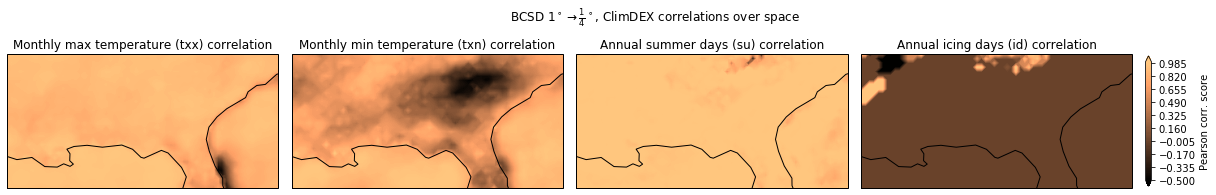

In [20]:
print(f'correlation, txx: {np.mean(txx_corr)} txn: {np.mean(txn_corr)} txsd: {np.mean(txsd_corr)} txid: {np.mean(txid_corr)}')
fig, axs, plot_fn = image_map_factory(1, 4, figsize=(6,4))
plot_fn(axs[0], txx_corr.squeeze(), hr_test.lat, hr_test.lon, title='Monthly max temperature (txx) correlation', cmap='copper')
plot_fn(axs[1], txn_corr.squeeze(), hr_test.lat, hr_test.lon, title='Monthly min temperature (txn) correlation', cmap='copper')
plot_fn(axs[2], txsd_corr.squeeze(), hr_test.lat, hr_test.lon, title='Annual summer days (su) correlation', cmap='copper')
cs = plot_fn(axs[3], txid_corr.squeeze(), hr_test.lat, hr_test.lon, title='Annual icing days (id) correlation', cmap='copper')
fig.colorbar(cs, ax=axs.ravel().tolist(), orientation='vertical', shrink=0.6, pad=0.01).set_label('Pearson corr. score')
fig.suptitle('BCSD $1^\\circ \\rightarrow \\frac{1}{4}^\\circ$, ClimDEX correlations over space', y=0.9)
plt.show()

In [8]:
# Southeast-US PRCP
lr_train, lr_test, hr_train, hr_test = get_train_test_splits(erai_deg1, ras_deg14, southeast_us, scale=4)
uri = metrics_file_uri('bcsd-final', '867868a48ad94a69af767132010d36b2')
with gcs.open(uri) as f:
    metrics = np.load(f)
    ar20_corr, prcptot_corr, cdd_corr, cwd_corr, rx1_corr, rx5_corr = compute_metrics_prcp(hr_test, metrics)

correlation, ar20: 0.9099091441880599 prcptot: 0.9326924059194459 cdd: 0.5255368245706156 cwd: 0.5407532542449197, rx1: 0.33281381004246974, rx5: 0.46858145623832204


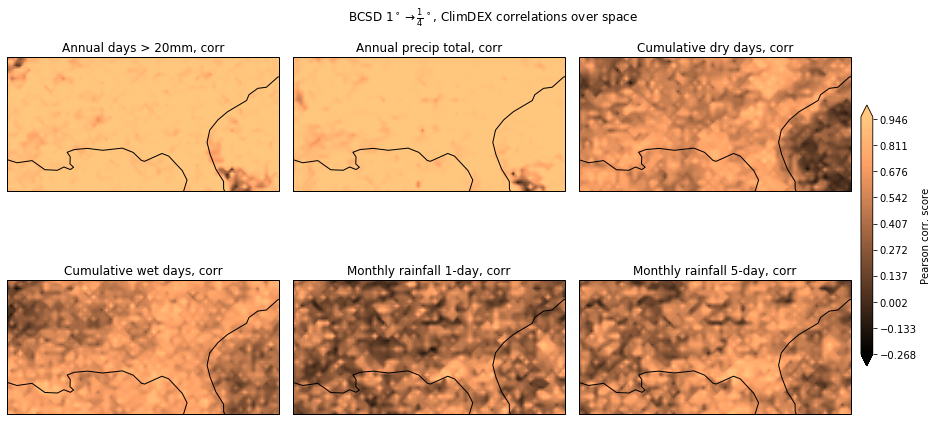

In [10]:
print(f'correlation, ar20: {np.mean(ar20_corr)} prcptot: {np.mean(prcptot_corr)} cdd: {np.mean(cdd_corr)} cwd: {np.mean(cwd_corr)}, rx1: {np.mean(rx1_corr)}, rx5: {np.mean(rx5_corr)}')
fig, axs, plot_fn = image_map_factory(2, 3, figsize=(6,4))
plot_fn(axs[0,0], ar20_corr.squeeze(), hr_test.lat, hr_test.lon, title='Annual days > 20mm, corr', cmap='copper')
plot_fn(axs[0,1], prcptot_corr.squeeze(), hr_test.lat, hr_test.lon, title='Annual precip total, corr', cmap='copper')
plot_fn(axs[0,2], cdd_corr.squeeze(), hr_test.lat, hr_test.lon, title='Cumulative dry days, corr', cmap='copper')
plot_fn(axs[1,0], cwd_corr.squeeze(), hr_test.lat, hr_test.lon, title='Cumulative wet days, corr', cmap='copper')
cs = plot_fn(axs[1,1], rx1_corr.squeeze(), hr_test.lat, hr_test.lon, title='Monthly rainfall 1-day, corr', cmap='copper')
cs = plot_fn(axs[1,2], rx5_corr.squeeze(), hr_test.lat, hr_test.lon, title='Monthly rainfall 5-day, corr', cmap='copper')
fig.colorbar(cs, ax=axs.ravel().tolist(), orientation='vertical', shrink=0.6, pad=0.01).set_label('Pearson corr. score')
fig.suptitle('BCSD $1^\\circ \\rightarrow \\frac{1}{4}^\\circ$, ClimDEX correlations over space', y=0.9)
plt.show()

### Bano-Medina CNN-10

In [11]:
from experiments.maxt_experiment_base import preprocess_fold_maxt, eval_metrics
encoder = load_model('data/saved_models/bmd-epoch50-seus.h5')
# workaround for loaded model not working; just pull out the weights and set them in a new model
# encoder = create_bmd_cnn10(lr_test.lat.size, lr_test.lon.size, c_out=2, scale=4)
# for (loaded, layer) in zip(loaded_encoder.layers, encoder.layers):
#     layer.set_weights(loaded.get_weights())
model = VariationalModel(encoder, normal())
lr_train, lr_test, hr_train, hr_test = get_train_test_splits(erai_deg1[['MAXT']], ras_deg14[['MAXT']], southeast_us, scale=4)
data = preprocess_fold_maxt(((lr_train, hr_train), (lr_test, hr_test)))
x_test = data.test[0].to_array('chan').transpose('Time', 'lat', 'lon', 'chan').astype(np.float32)
y_test = data.test[1].to_array('chan').transpose('Time', 'lat', 'lon', 'chan').astype(np.float32)
y_pred = model.mean(x_test.values)
y_true = tf.constant(y_test.values)
indices = tdex.indices('Time', convert_units_fn=lambda x: x+273.15)
metrics = eval_metrics(indices, y_true, y_pred, y_test.coords, data.monthly_means[1]['MAXT'])

/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow_core/python/training/tracking/data_structures.py:669: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(wrapped_dict, collections.Mapping):


In [20]:
txx_corr, txn_corr, txsd_corr, txid_corr = compute_metrics_maxt(hr_test, metrics)

correlation, txx: 0.9882781541935612 txn: 0.9863639202373202 txsd: 0.9988231881665267 txid: 0.020585145589378077


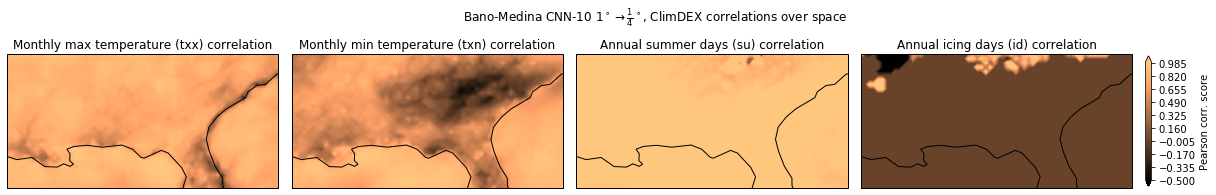

In [22]:
print(f'correlation, txx: {np.mean(txx_corr)} txn: {np.mean(txn_corr)} txsd: {np.mean(txsd_corr)} txid: {np.mean(txid_corr)}')
fig, axs, plot_fn = image_map_factory(1, 4, figsize=(6,4))
plot_fn(axs[0], txx_corr.squeeze(), hr_test.lat, hr_test.lon, title='Monthly max temperature (txx) correlation', cmap='copper')
plot_fn(axs[1], txn_corr.squeeze(), hr_test.lat, hr_test.lon, title='Monthly min temperature (txn) correlation', cmap='copper')
plot_fn(axs[2], txsd_corr.squeeze(), hr_test.lat, hr_test.lon, title='Annual summer days (su) correlation', cmap='copper')
cs = plot_fn(axs[3], txid_corr.squeeze(), hr_test.lat, hr_test.lon, title='Annual icing days (id) correlation', cmap='copper')
fig.colorbar(cs, ax=axs.ravel().tolist(), orientation='vertical', shrink=0.6, pad=0.01).set_label('Pearson corr. score')
fig.suptitle('Bano-Medina CNN-10 $1^\\circ \\rightarrow \\frac{1}{4}^\\circ$, ClimDEX correlations over space', y=0.9)
plt.show()

In [1]:
import mlflow
layers = 3
depth = 4
epochs = 50
region = 'southeast_us'
lam = 0.1
# run experiment
mlflow.run('.', 'glow-jflvm', experiment_name='glow-jflvm-final',
           parameters={'scale': 4, 'layers': layers, 'depth': depth, 'lam': lam, 'epochs': epochs,
                       'region': region, 'var': 'PRCP', 'data_lr': 'erai/daily-1deg', 'alpha': 0.0, 'mode': 'test'}, use_conda=False)

2020/03/10 15:50:38 INFO mlflow.projects: === Created directory /tmp/tmpiqiqgs7l for downloading remote URIs passed to arguments of type 'path' ===
2020/03/10 15:50:38 INFO mlflow.projects: === Running command 'python run_experiment.py glow-jflvm erai/daily-1deg --scale 4 --layers 3 --depth 4 --min-filters 32 --max-filters 256 --lam 0.1 --alpha 0.0 --prior standard --dnet-layers 3 --dnet-filters 64 --splits 3 --batch-size 10 --var PRCP --epochs 50 --validate-freq 5 --region southeast_us --mode test --auth gcs.secret.json' in run with ID '06d147ee7ae143a9a9f0e080f1bf7a7c' === 
2020/03/10 17:26:06 INFO mlflow.projects: === Run (ID '06d147ee7ae143a9a9f0e080f1bf7a7c') succeeded ===


In [2]:
layers = 3
depth = 4
epochs = 50
region = 'pacific_nw'
lam = 0.1
# run experiment
mlflow.run('.', 'glow-jflvm', experiment_name='glow-jflvm-final',
           parameters={'scale': 4, 'layers': layers, 'depth': depth, 'lam': lam, 'epochs': epochs,
                       'region': region, 'var': 'PRCP', 'data_lr': 'erai/daily-1deg', 'alpha': 0.0, 'mode': 'test'}, use_conda=False)

2020/03/10 17:26:06 INFO mlflow.projects: === Created directory /tmp/tmplsuc4j0q for downloading remote URIs passed to arguments of type 'path' ===
2020/03/10 17:26:06 INFO mlflow.projects: === Running command 'python run_experiment.py glow-jflvm erai/daily-1deg --scale 4 --layers 3 --depth 4 --min-filters 32 --max-filters 256 --lam 0.1 --alpha 0.0 --prior standard --dnet-layers 3 --dnet-filters 64 --splits 3 --batch-size 10 --var PRCP --epochs 50 --validate-freq 5 --region pacific_nw --mode test --auth gcs.secret.json' in run with ID 'c152315e86224d85b39386c62d829279' === 
2020/03/10 19:00:51 INFO mlflow.projects: === Run (ID 'c152315e86224d85b39386c62d829279') succeeded ===
